## Spectral Kurtosis flagging revisited
### Hyperseti technote 009

SK flagging was not working on ATA Mars data (https://github.com/UCBerkeleySETI/hyperseti/issues/73).

I found that the flag thresholds were incorrect. I will replace the SK flagging logic with parameters shown here.

In [403]:
import numpy as np
from astropy import units as u
import setigen as stg
import matplotlib.pyplot as plt
import h5py
import hdf5plugin

plt.rcParams['font.size'] = 12

### Spectral kurtosis functions

In [380]:
def sk(x, N_acc):
    x_sum  = np.sum(x, axis=0)
    x2_sum = np.sum(x**2, axis=0)
    n = x.data.shape[0]
    return (N_acc*n+1) / (n-1) * (n*(x2_sum / (x_sum*x_sum)) - 1).squeeze()

def sk_flag(data, N_acc, n_sigma=5):
    _sk = sk(data, N_acc)

    # TODO: This is nonsense and doesn't work.
    log_sk   = np.log2(_sk) 
    std_log  = 2.0 / np.sqrt(N_acc)         # Based on setigen
    mean_log = -1.25 / N_acc                # Based on setigen 
    
    
    mask  = np.abs(log_sk) > np.abs(mean_log) + (std_log * n_sigma)
    # also mask either side of a masked value
    mask[1:]  = np.logical_or(mask[1:], mask[0:-1])
    mask[:-1] = np.logical_or(mask[:-1], mask[1:])
    return mask

### Compare setigen noise against actual data 

2/sqrt(N_t) = 0.5
Mean(log2(SK)): -0.091 	 STD(log2(SK)): 0.529
Mean(log2(SK)): -0.1 	 STD(log2(SK)): 0.55
Mean(log2(SK)): -0.11 	 STD(log2(SK)): 0.559
Mean(log2(SK)): -0.091 	 STD(log2(SK)): 0.524
Mean(log2(SK)): -0.093 	 STD(log2(SK)): 0.544


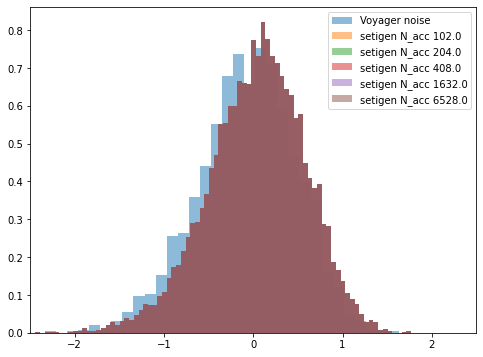

In [286]:
# Load voyager data
h5 = h5py.File('../test/test_data/Voyager1.single_coarse.fine_res.h5', 'r')
ds = h5['data'][:, 0, :2**20]
# Extract a noise-like part of dataset
dv = ds[:, 2**18:2**20-2**18][:,:2**14]

# Plot voyager data
plt.figure(figsize=(8, 6))
_ = plt.hist(np.log2(sk(noise, N_acc)),density=True, bins=32, alpha=0.5, label='Voyager noise')

# Generate and plot setigen with same N_t as voyager
N_t = 16
print(f"2/sqrt(N_t) = {2 / np.sqrt(N_t)}")
for _N in (1, 2, 4, 16, 64):
    df = 2.7939677238464355
    dt = 18.253611008  * _N
    N_acc = df*dt*2

    frame = stg.Frame(fchans=2048*u.pixel,
                      tchans=N_t*u.pixel,
                      df=df*u.Hz,
                      dt=dt*u.s,
                      fch1=1*u.GHz)
    noise = frame.add_noise(x_mean=1e9, noise_type='chi2')

    _ = plt.hist(np.log2(sk(dv, 51*2)), density=True, bins=101, alpha=0.5, label=f"setigen N_acc {N_acc}")

    S = sk(noise, N_acc)
    print(f"Mean(log2(SK)): {np.mean(np.log2(S)):.2} \t STD(log2(SK)): {np.std(np.log2(S)):.3}")

plt.xlim(-2/np.sqrt(N_t)*5, 2/np.sqrt(N_t)*5)
plt.legend()

Here we have plotted log2(SK), which produces a nice Gaussian. If SK is plotted all values > 0 and small values are hard to see.

Takeaway: Noise stats of setigen match actual data well.

### STDEV and mean of SK values 

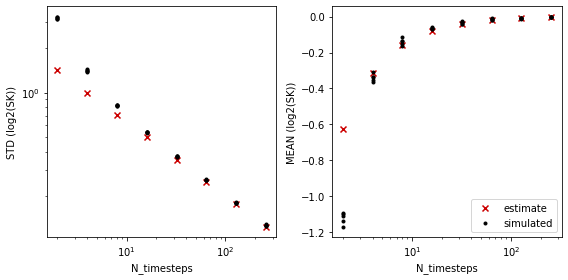

In [281]:
plt.figure(figsize=(8, 4))

for N_t in (2, 4, 8, 16, 32, 64, 128, 256): 

    #print(f"2/sqrt(N_t) = {2 / np.sqrt(N_t)}")
    plt.subplot(1,2,1)
    plt.scatter(N_t, 2 / np.sqrt(N_t), marker='x', color='#cc0000')
    
    plt.subplot(1,2,2)
    plt.scatter(N_t, -1.25 / N_t, marker='x', color='#cc0000')
    for _N in (1, 2, 4, 16, 64):
        df = 2.7939677238464355
        dt = 18.253611008  * _N
        N_acc = df*dt*2

        frame = stg.Frame(fchans=8192*u.pixel,
                          tchans=N_t*u.pixel,
                          df=df*u.Hz,
                          dt=dt*u.s,
                          fch1=1*u.GHz)
        noise = frame.add_noise(x_mean=1e9, noise_type='chi2')

        #_ = plt.hist(np.log2(sk(dv, 51*2)), density=True, bins=101, alpha=0.5, label=f"setigen N_acc {N_acc}")
        plt.subplot(1,2,1)
        S = sk(noise, N_acc)
        #print(f"Mean(log2(SK)): {np.mean(np.log2(S)):.2} \t STD(log2(SK)): {np.std(np.log2(S)):.3}")
        
        plt.scatter(x=N_t, y=np.std(np.log2(S)), color='black', marker='.')
        plt.loglog()
        
        plt.subplot(1,2,2)
        plt.scatter(x=N_t, y=np.median(np.log2(S)), color='black', marker='.')
        plt.semilogx()
plt.subplot(1,2,1)
plt.xlabel("N_timesteps")
plt.ylabel("STD (log2(SK))")
plt.subplot(1,2,2)
plt.xlabel("N_timesteps")
plt.ylabel("MEAN (log2(SK))")
plt.legend(['estimate', 'simulated'])
plt.tight_layout()

Note: The original SK papers do not mention applying log2() to output. The std=2/sqrt(N) theoretical value (red x markers on left) is in the literature, but my log2(mean(SK)) = -1.25 / N  (red X markers on right), is just a guessed fit to the trend.

### Testing new SK flagger

Flagged frac: 0.29 %


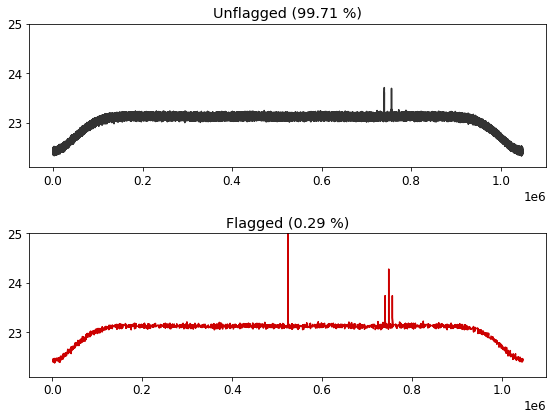

In [426]:
flags = sk_flag(ds, 102, n_sigma=10)
flag_pc = (np.sum(flags) / len(x) * 100)

print(f"Flagged frac: {flag_pc:.2f} %")

plt.figure(figsize=(8, 6))
plt.subplot(2,1,1)
plt.plot(x[~flags], np.log(ds.mean(axis=0))[~flags], c='#333333')
plt.ylim(22.1, 25)
plt.title(f"Unflagged ({100-flag_pc:.2f} %)")

plt.subplot(2,1,2)
plt.title(f"Flagged ({flag_pc:.2f} %)")
plt.plot(x[flags], np.log(ds.mean(axis=0))[flags], c='#cc0000')
plt.ylim(22.1, 25)
plt.tight_layout()

The flagger misses some channels where the voyager signal is, but gets the DC bin and most of the voyager signal.

My handwaving argument to explain this is is that within the sideband, the voyager datastream is quasi noise-like. Channels where the transmission is consistent (i.e. signal never fully drifts out of channel) will have more noise-like statistics.